In [1]:

import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup 
import os
import shutil
import glob
import yaml
import torch
!pip install easyocr -qq
import easyocr
import cv2 as cv
import matplotlib.pyplot as plt
import easyocr
%matplotlib inline
import pickle 
import cv2
from IPython.display import Image, display


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.  *Initialize The Preprocessing Function*
> 

In [2]:

def normalized_coordinates(filename, width, height, xmin, ymin, xmax, ymax):
    """Take in image coordinates (unnormalized) as input, return normalized values 
    """
    
    xmin, xmax = xmin / width, xmax / width
    ymin, ymax = ymin / height, ymax/ height

    width = xmax-xmin
    height = ymax-ymin
    x_center = xmin + (width / 2)
    y_center = ymin + (height / 2)

    return x_center, y_center, width, height

def write_label(filename, x_center, y_center, width, height):
    """Save image's coordinates in text file named "filename"
    """
    with open(filename, mode='w') as outf:
        outf.write(f"{0} {x_center} {y_center} {width} {height}\n")

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d

def build_data(dir_folder, ann_file_list, img_dir):
    """Write xml labels to text file with specifications format, save at 'labels' folder.
        Move image to 'images' folder
    """
    images_folder = f"{dir_folder}/images"
    labels_folder = f"{dir_folder}/labels"
    
    os.makedirs(images_folder, exist_ok = True)
    os.makedirs(labels_folder, exist_ok = True)


    for ann_file in ann_file_list:
        with open(ann_file, 'r') as f:
            label = parse_xml_tags(f.read())
         
        img_file_name = label['filename']
        x_center, y_center, width, height = normalized_coordinates(**label)
         
        # save at 'labels' folder
        write_label(f"{labels_folder}/{img_file_name.split('.')[0]}.txt", x_center, y_center, width, height)
         
         # Move image to 'images' folder
        shutil.copy(f"{img_dir}/{img_file_name}", f"{images_folder}/{img_file_name}")

# 2.  **Loading Dataset images and it's annotation **

In [3]:
dir_folder = "/kaggle/working/plate_datasets"
val_dict='/kaggle/working/plate_datasets/val'
ann_list = glob.glob('/kaggle/input/car-plate-detection/annotations/*')
build_data(dir_folder, ann_list, "/kaggle/input/car-plate-detection/images")

ann_list2 = glob.glob('/kaggle/input/number-plate-detection/images/*.xml')
build_data(val_dict, ann_list2, "/kaggle/input/number-plate-detection/images")


In [19]:

data = {
    "path": dir_folder,
    "train": "images",
    "val": "/kaggle/working/plate_datasets/val",
    "names": {0: "car_lisence_plate"},
    'test':'/kaggle/input/fifty-states-car-license-plates-dataset/Fifty States License Plates'
    }

with open('/kaggle/working/plate_datasets/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [20]:
assert len(os.listdir("/kaggle/working/plate_datasets/labels")) == len(os.listdir("/kaggle/working/plate_datasets/images"))

  # 3.  **Trainig YOLOV8 on Our Custom Data**

In [8]:
!git clone https://github.com/ultralytics/ultralytics
%pip install -qe ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 20961, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 20961 (delta 139), reused 176 (delta 117), pack-reused 20743
Receiving objects: 100% (20961/20961), 11.22 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (14771/14771), done.
Note: you may need to restart the kernel to use updated packages.


In [21]:
mkdir /kaggle/working/ultralytics/mydata


mkdir: cannot create directory '/kaggle/working/ultralytics/mydata': File exists


In [22]:
mkdir /kaggle/working/ultralytics/mydata/images

mkdir: cannot create directory '/kaggle/working/ultralytics/mydata/images': File exists


In [11]:
mkdir /kaggle/working/ultralytics/mydata/labels


In [12]:
mkdir /kaggle/working/ultralytics/mydata/images/train


In [13]:
mkdir /kaggle/working/ultralytics/mydata/images/test


In [14]:
mkdir /kaggle/working/ultralytics/mydata/labels/train


In [15]:
mkdir /kaggle/working/ultralytics/mydata/labels/test


In [16]:
cd /kaggle/working/ultralytics/mydata


/kaggle/working/ultralytics/mydata


In [17]:

!wandb off


W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


In [23]:
 !yolo task=detect mode=train model=yolov8n.pt data=/kaggle/working/plate_datasets/dataset.yaml epochs=100 imgsz=640 batch=64 cache=disk 


100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 76.6MB/s]
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/plate_datasets/dataset.yaml, epochs=100, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=disk, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

  # 4.  **Model Metrics **

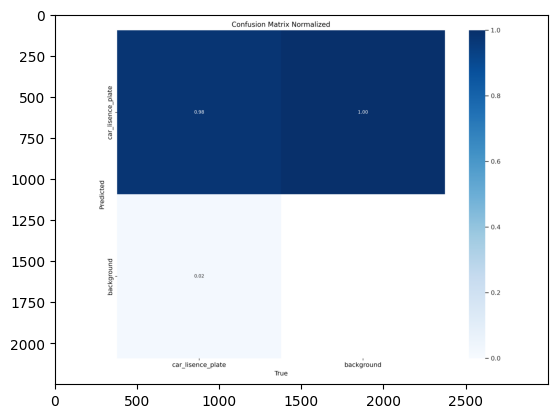

In [24]:
import matplotlib.pyplot as plt

results = plt.imread('/kaggle/working/ultralytics/runs/detect/train/confusion_matrix_normalized.png')
plt.imshow(results)
plt.show()


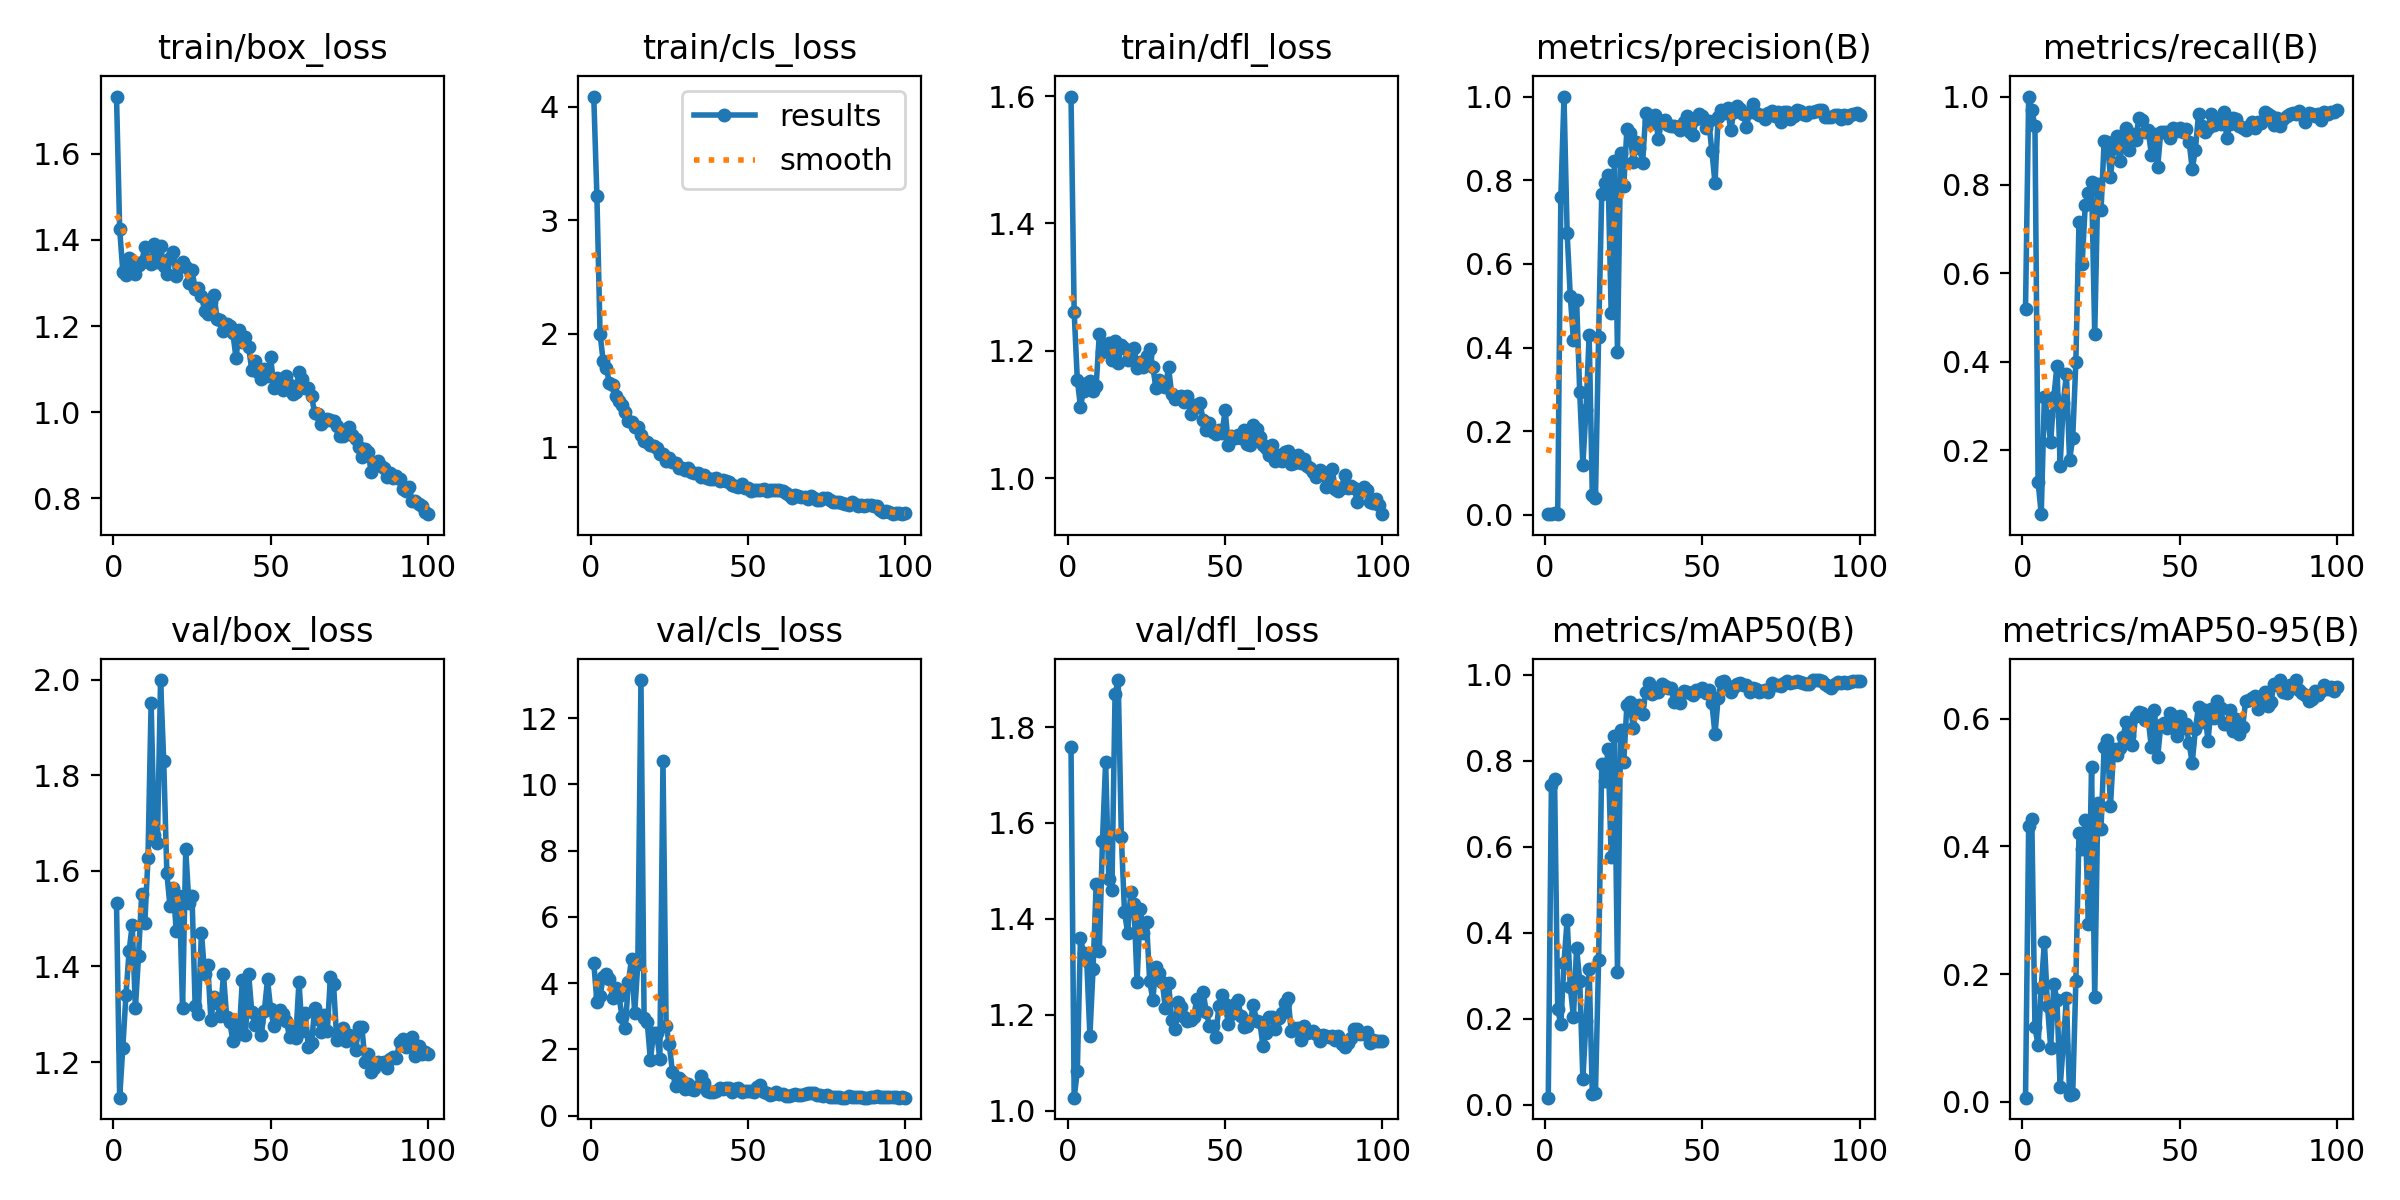

In [25]:
from IPython.display import Image, display

# Specify the file path
image_path = '/kaggle/working/ultralytics/runs/detect/train/results.png'

# Display the image
display(Image(filename=image_path))


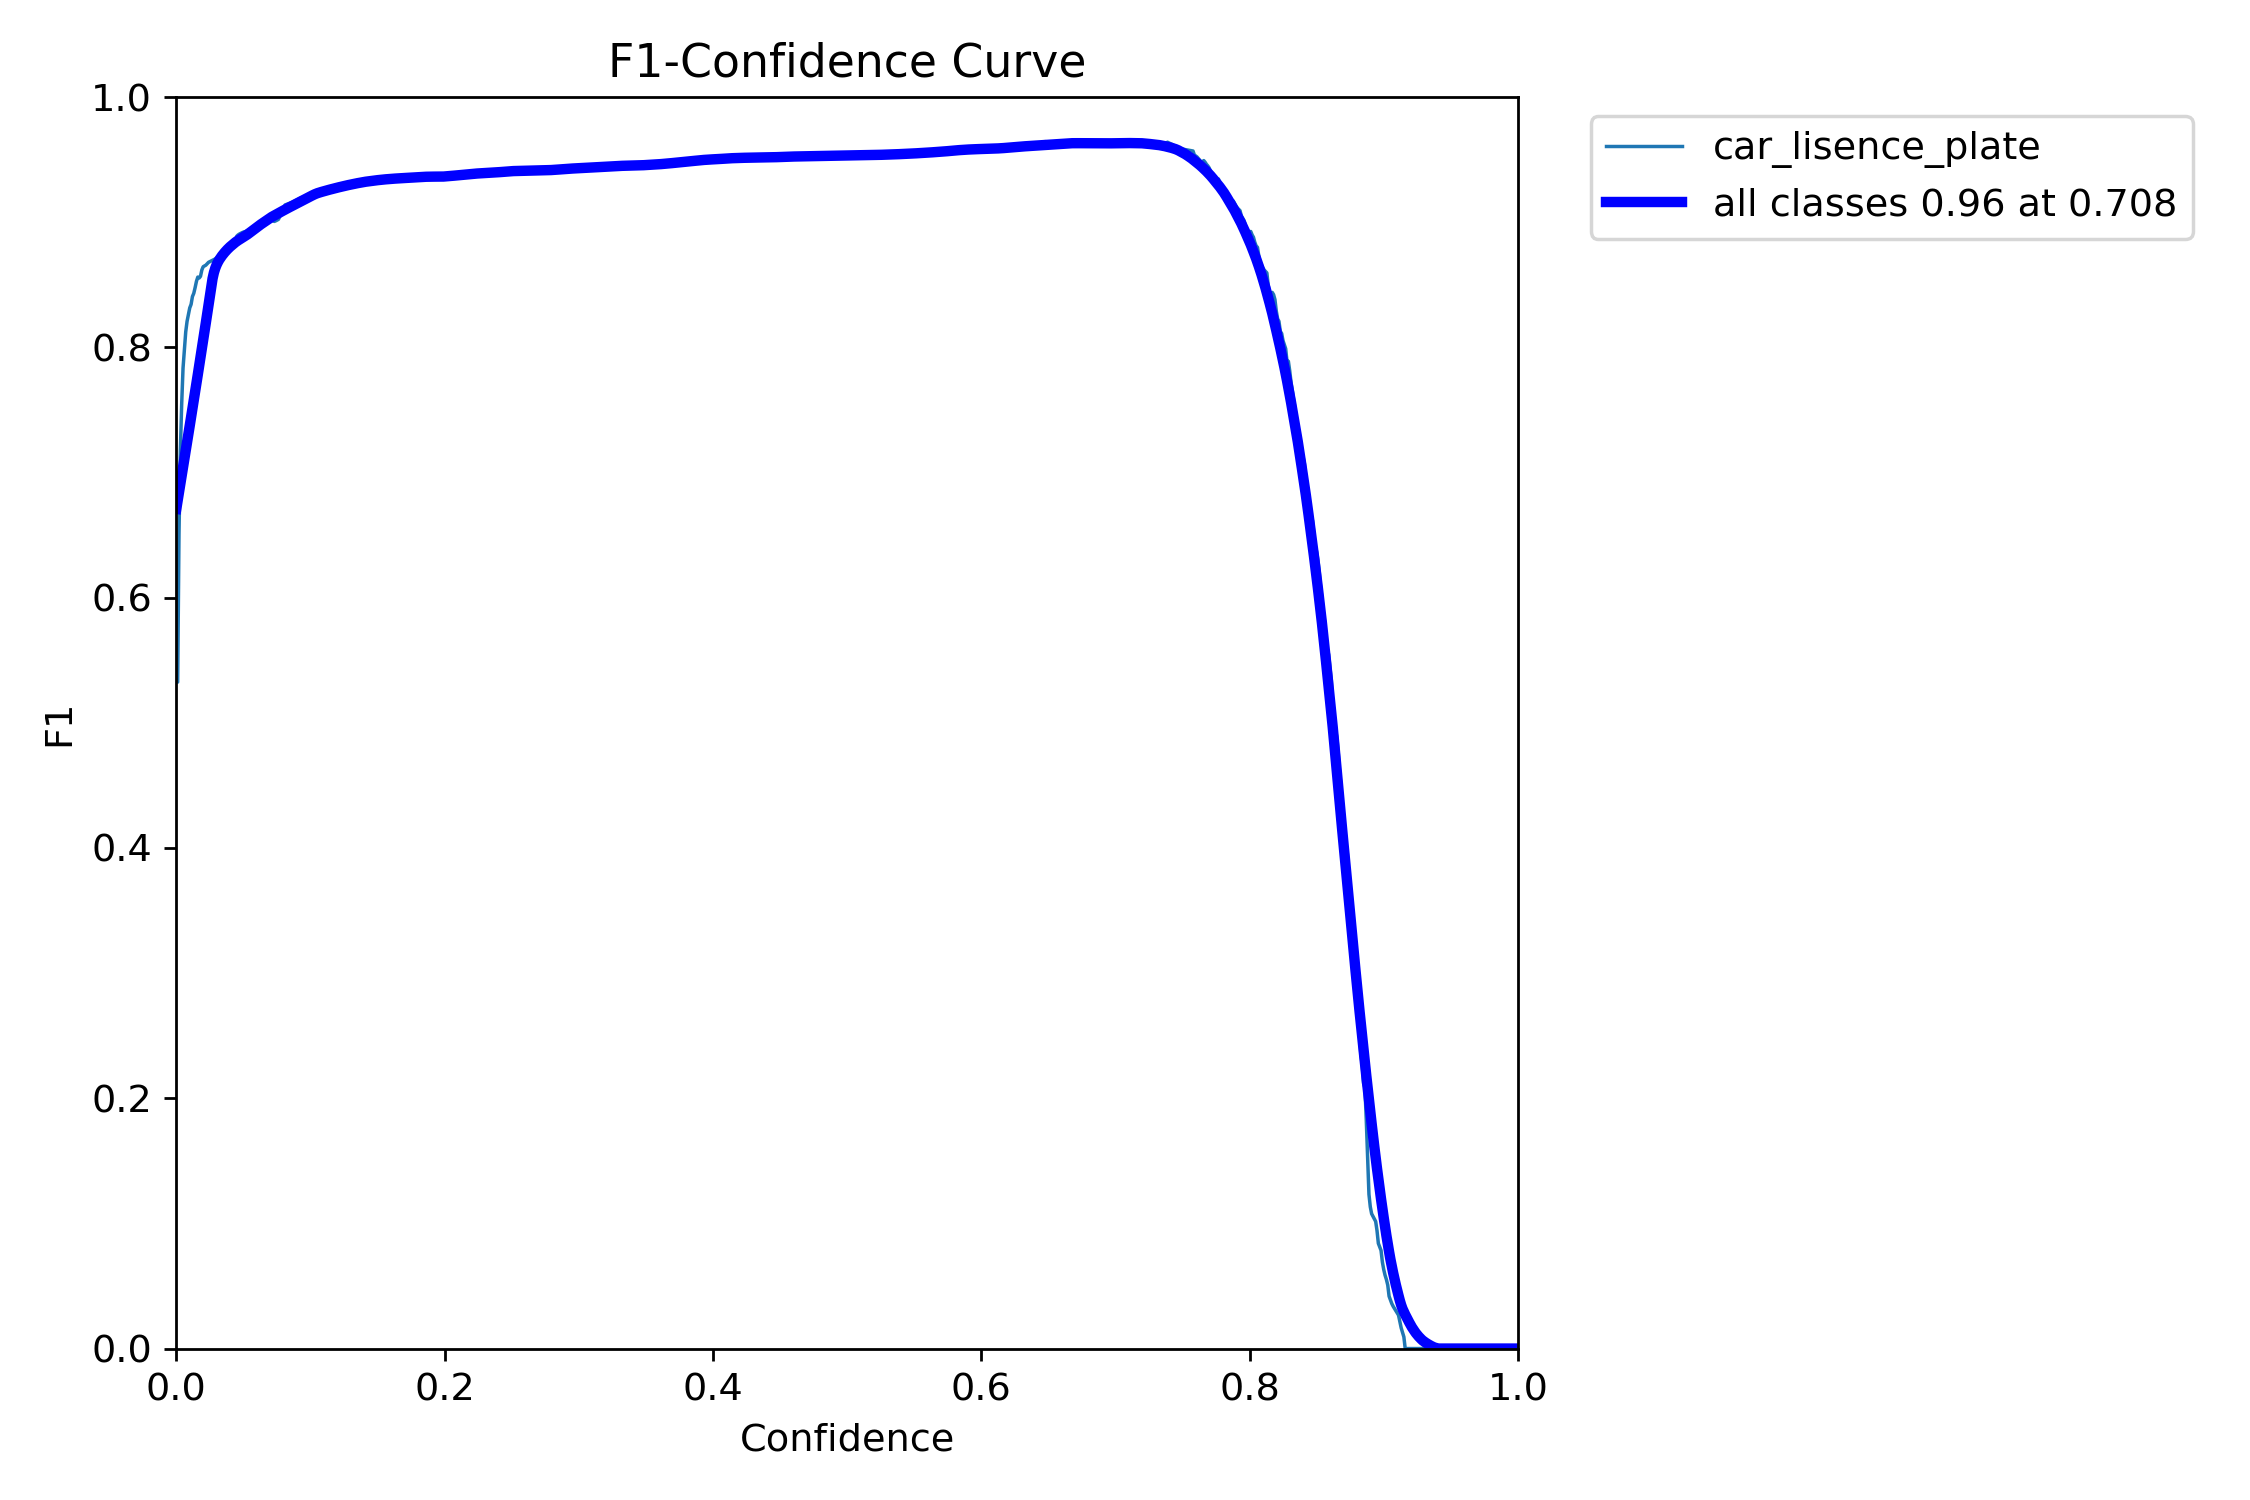

In [26]:
from IPython.display import Image, display

# Specify the file path
img_coo = '/kaggle/working/ultralytics/runs/detect/train/F1_curve.png'

# Display the image
display(Image(filename=img_coo))

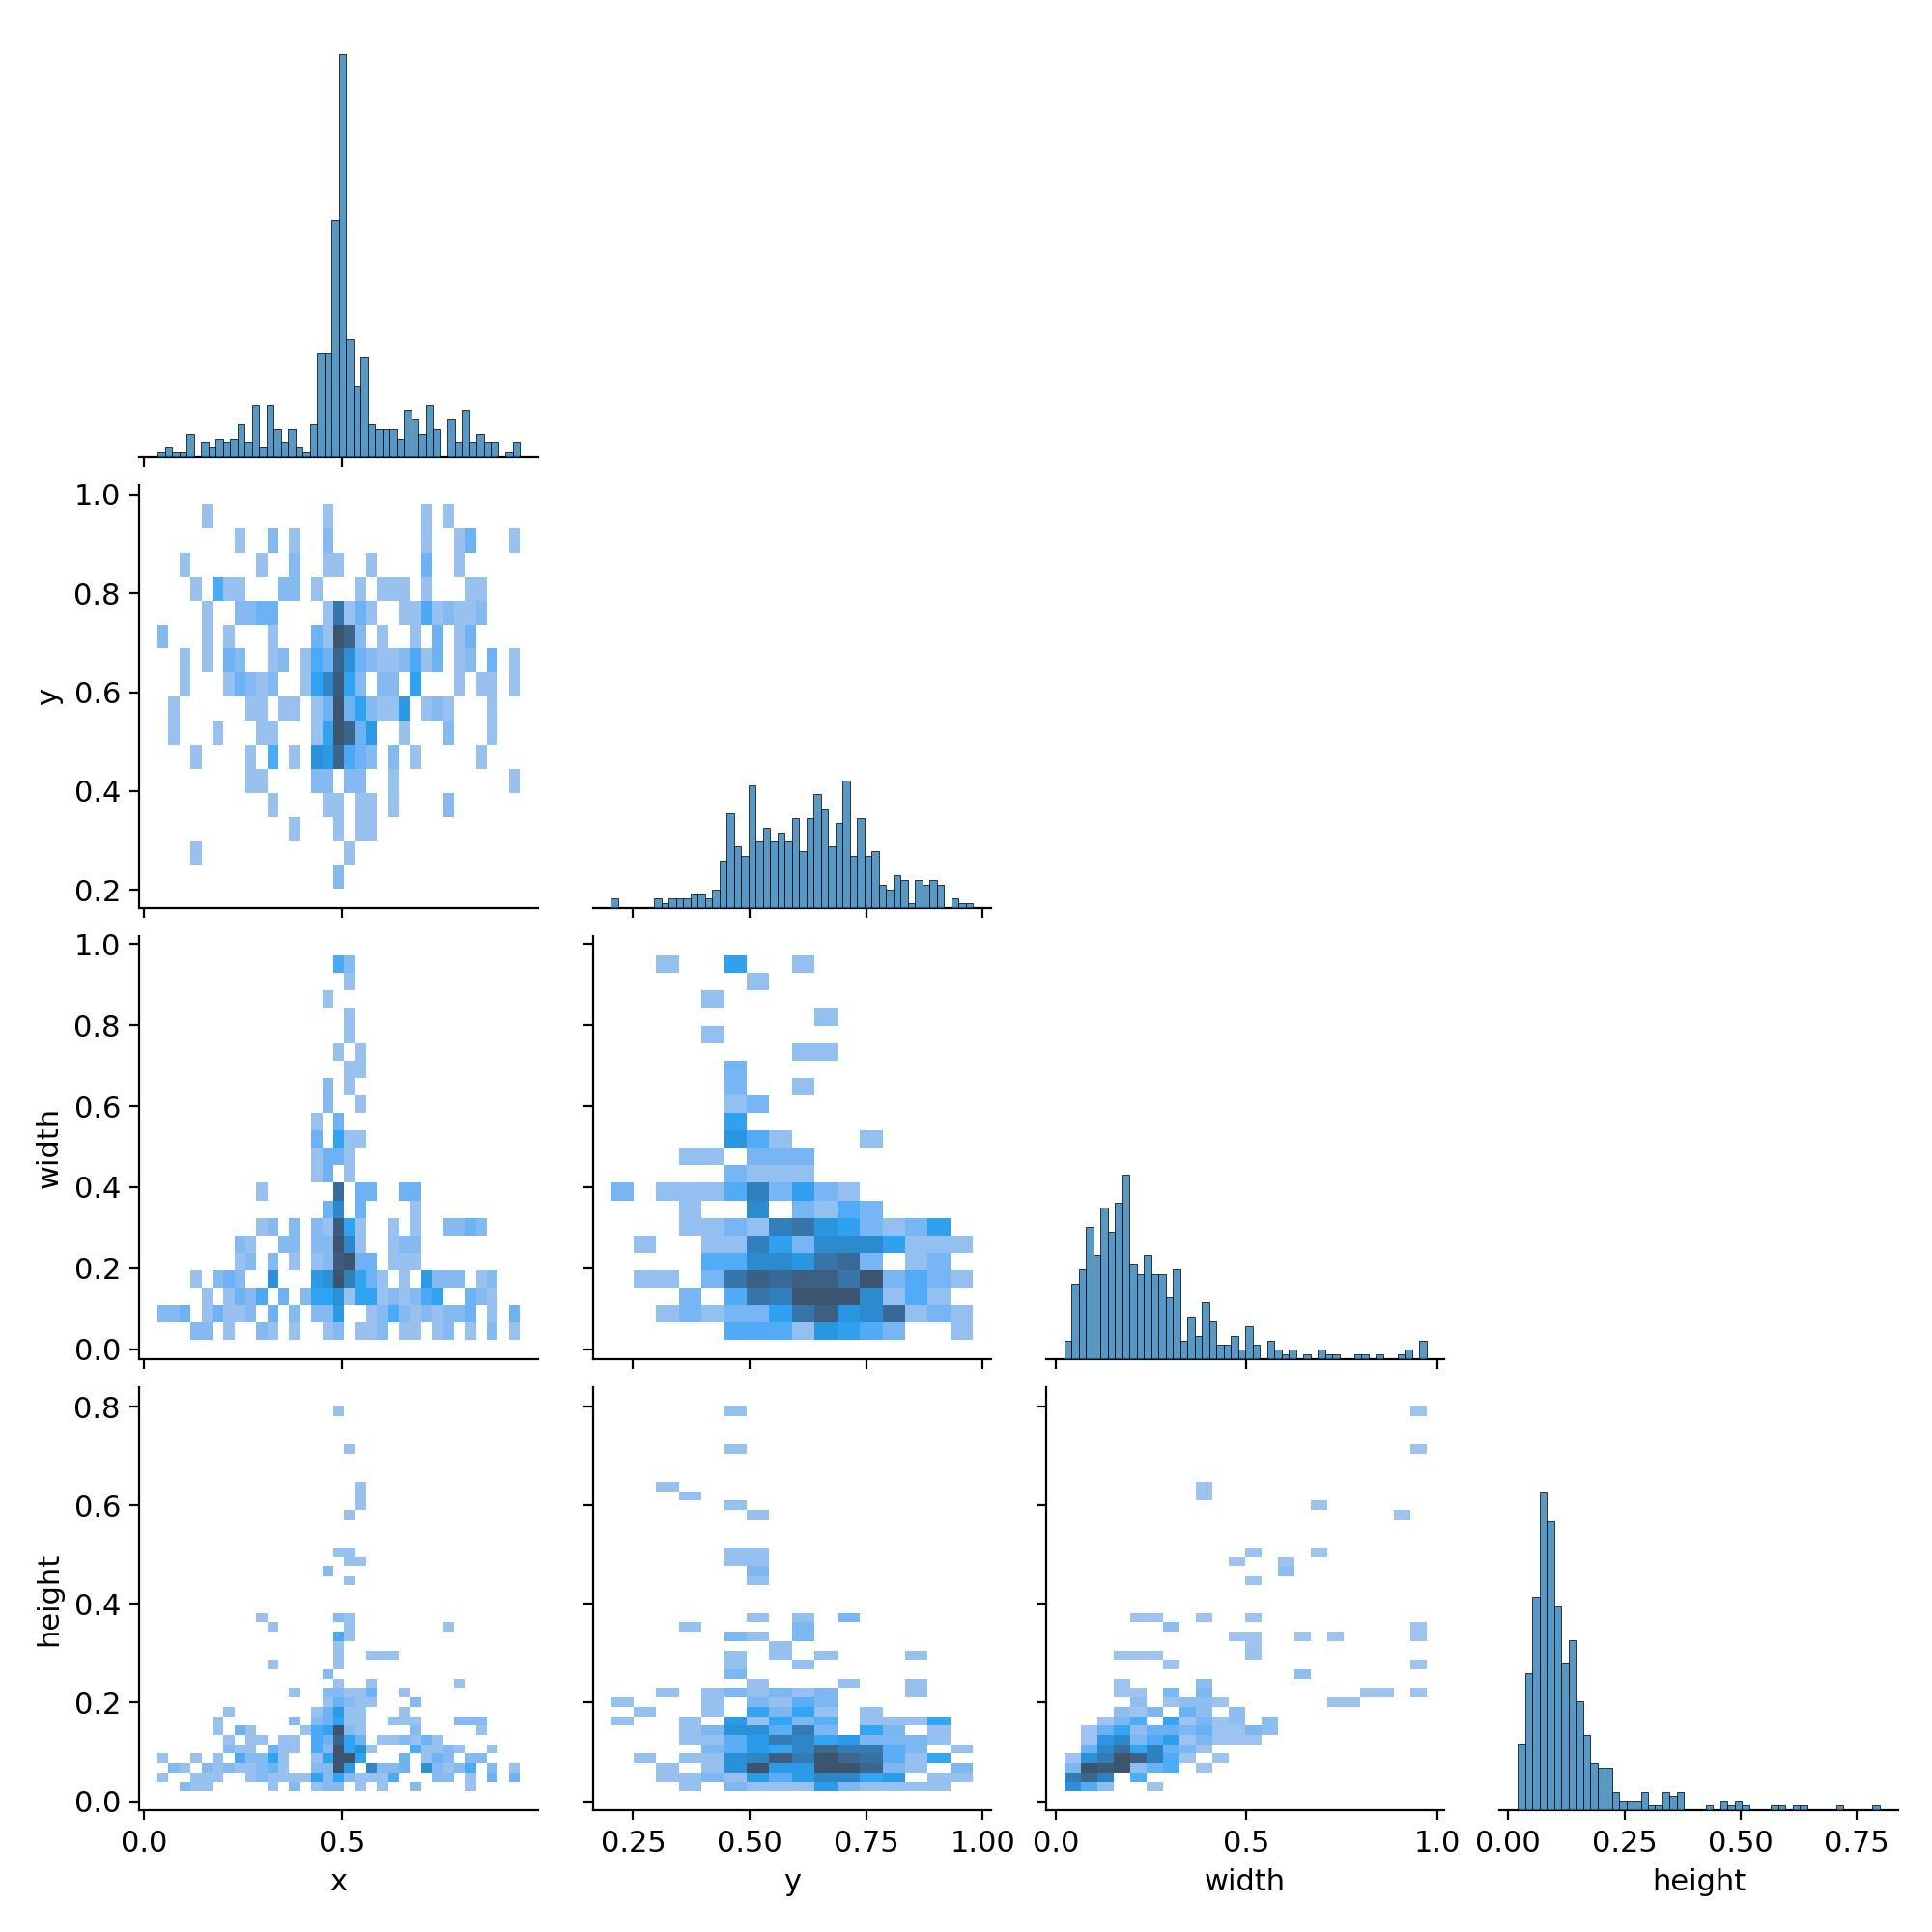

In [27]:

# Specify the file path
img_coo = '/kaggle/working/ultralytics/runs/detect/train/labels_correlogram.jpg'

# Display the image
display(Image(filename=img_coo))

  # 5.  **Checking Model performance on Data **

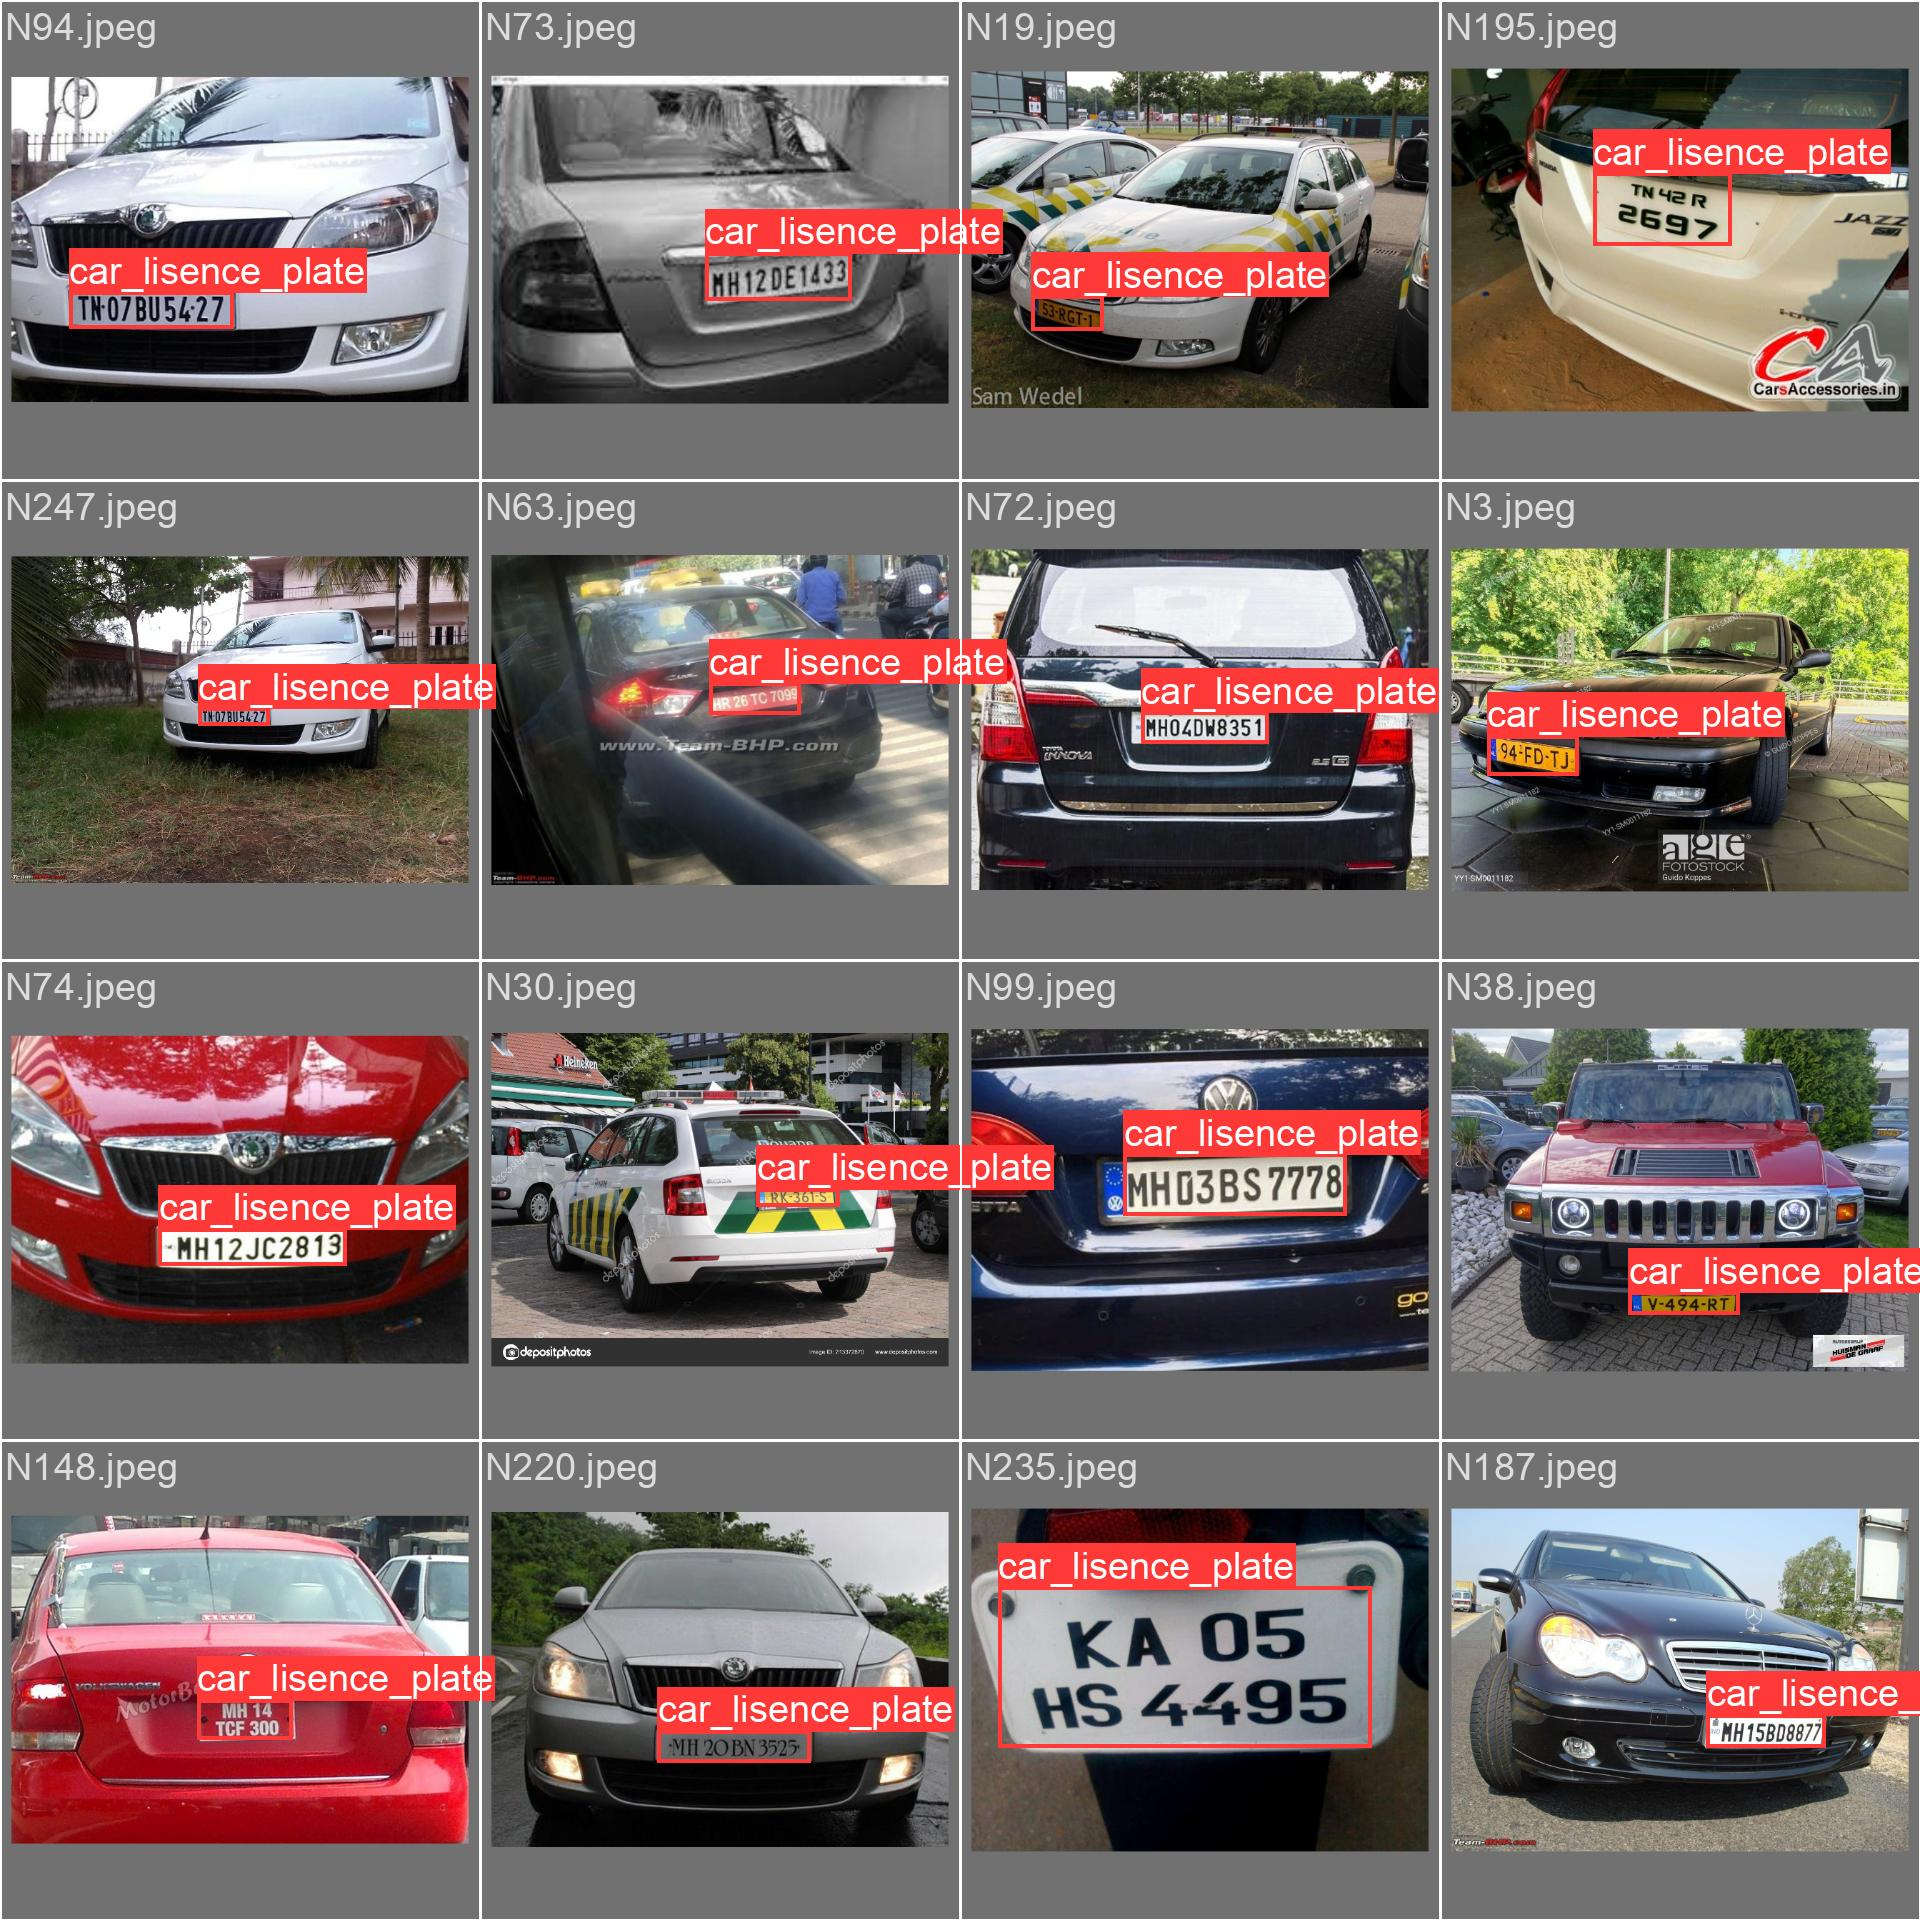

In [28]:


img_coo = '/kaggle/working/ultralytics/runs/detect/train/val_batch1_labels.jpg'

# Display the image
display(Image(filename=img_coo))

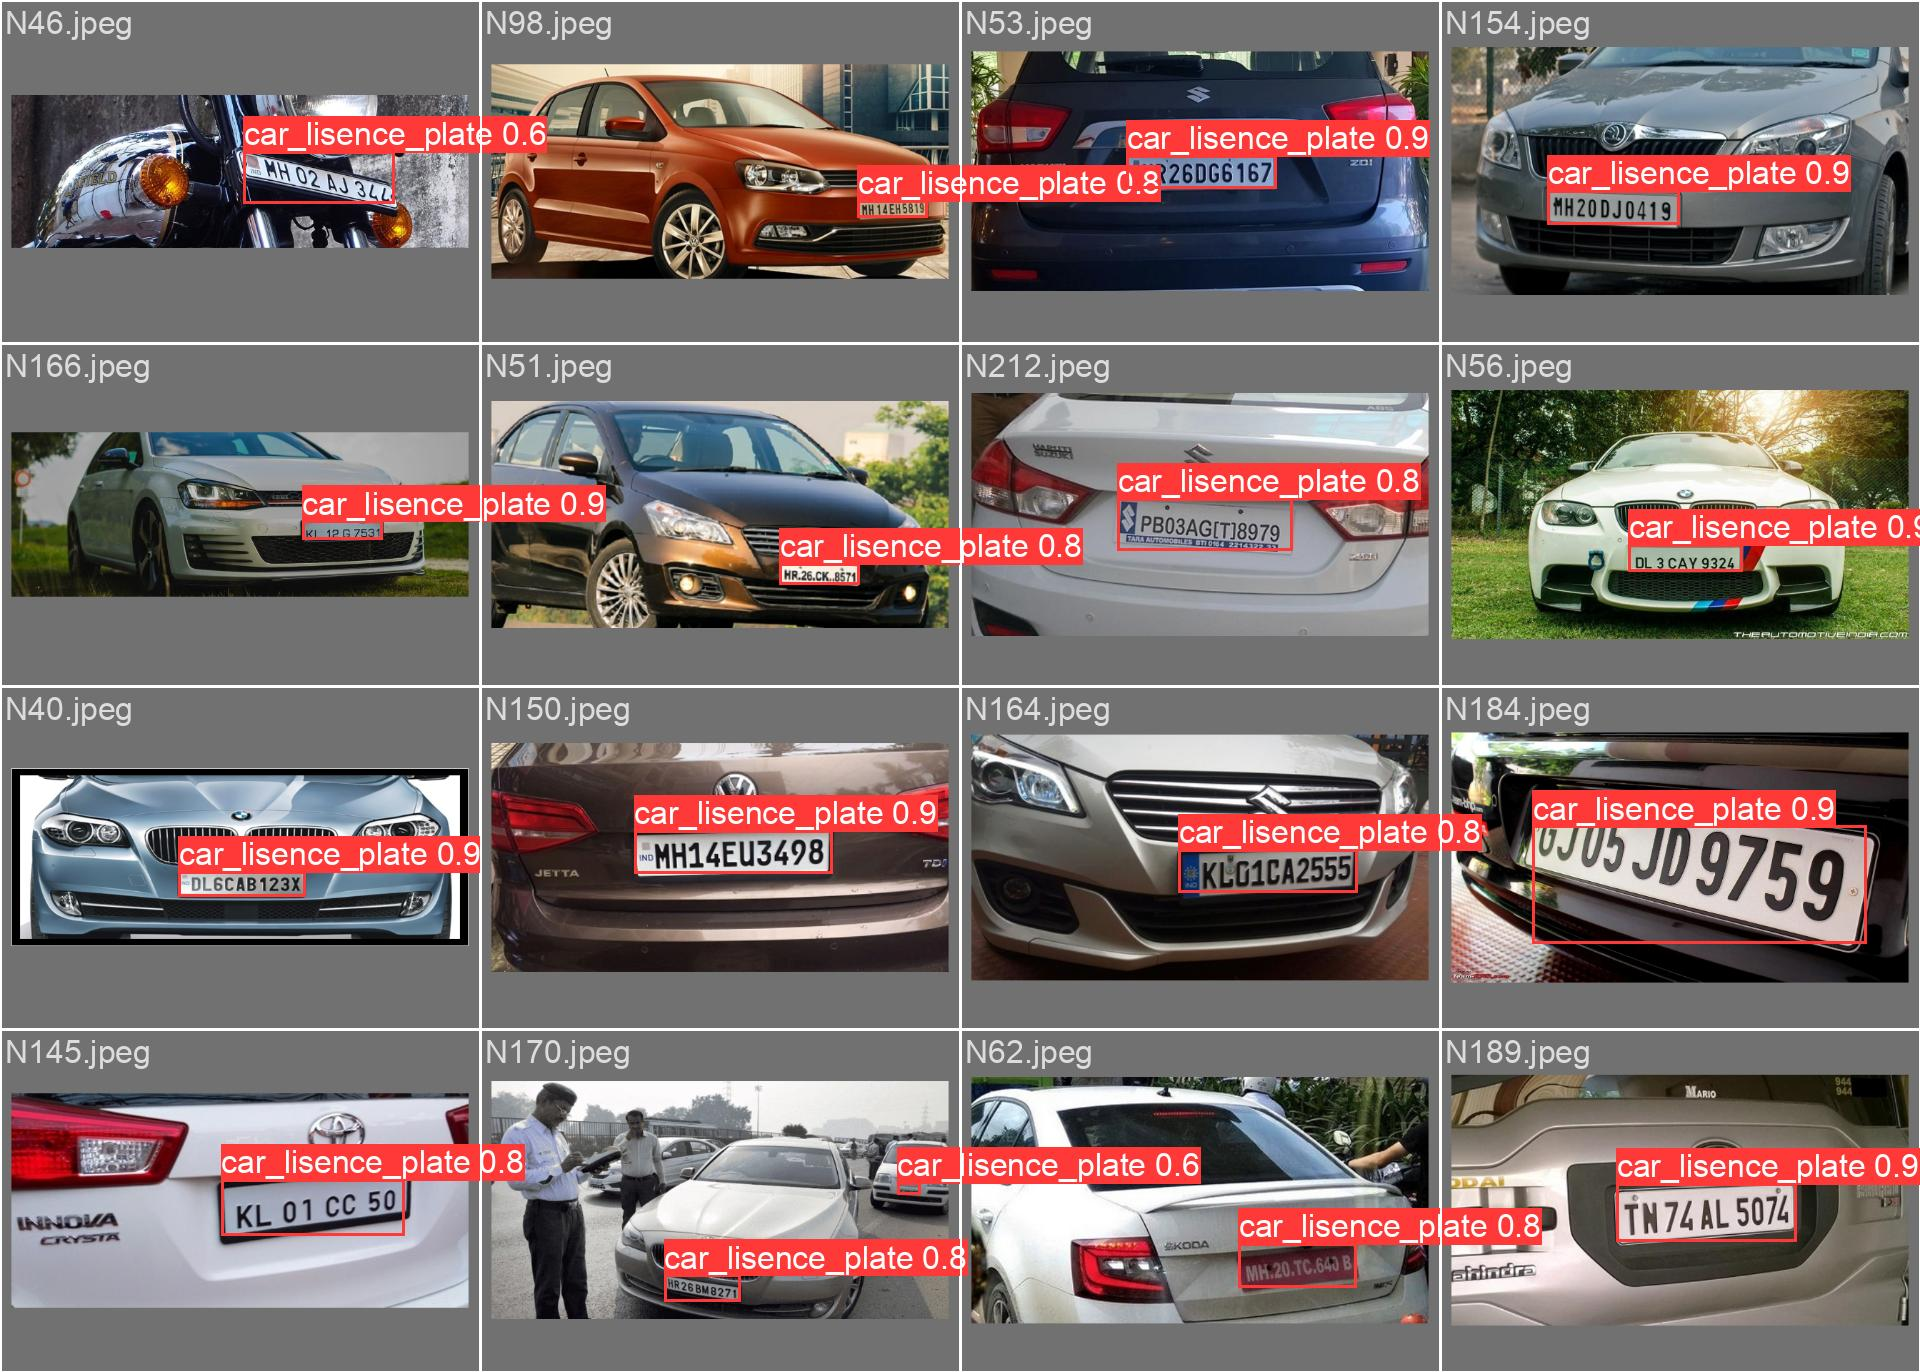

In [29]:
img_coo = '/kaggle/working/ultralytics/runs/detect/train/val_batch0_pred.jpg'

# Display the image
display(Image(filename=img_coo))